In [5]:
!pip install textblob
!pip install torch
!pip install praw
from textblob import TextBlob
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, LogisticRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import praw
import pdb
import warnings
warnings.filterwarnings("ignore")

In [17]:
clientID = 'VpVEXRwC5-nrbA'
clientSecret = 'XMql3JHOqhq2NatetFMFPkhBaCE'
userAgent = 'Reddit WebScraping'
reddit = praw.Reddit(client_id=clientID, client_secret=clientSecret, user_agent=userAgent)

In [ ]:
# Retrieve the top (most upvoted) 1k posts in the last year and add them to a Pandas dataframe
topPosts = []
subReddit = reddit.subreddit('all')
for post in tqdm(subReddit.top(time_filter = 'year', limit=1000), total=1000):
    topPosts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created_utc, post.author, post.is_self, post.over_18, post.spoiler, post.upvote_ratio])
    
topPosts = pd.DataFrame(topPosts,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created', 'author', 'is_self', 'over_18', 'spoiler', 'upvote_ratio'])
topPosts.to_csv("top1KPosts.csv", index=False)

In [ ]:
# Retrieve the most controversial (most downvoted) 1k posts in the last year and add them to a Pandas dataframe
controvertialPosts = []
subReddit = reddit.subreddit('all')
for post in tqdm(subReddit.controversial(time_filter = 'year', limit=1000), total=1000):
    controvertialPosts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created_utc, post.author, post.is_self, post.over_18, post.spoiler, post.upvote_ratio])
controvertialPosts = pd.DataFrame(controvertialPosts,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created', 'author', 'is_self', 'over_18', 'spoiler', 'upvote_ratio'])
controvertialPosts.to_csv("controvertial1KPosts.csv", index=False)

In [6]:
top1KPosts = pd.read_csv("top1kPosts.csv")
controversial1KPosts = pd.read_csv("controversial1kPosts.csv")

To avoid calling the Reddit API thousands of times, we have saved the results of 1k "Top" posts and 1k "Controversial" posts to a data frame. For all future analysis, we will be reading and modifying these data frames. 

In [7]:
topSubReddit = top1KPosts.subreddit.unique() # List of subreddits that have broken top 10k
topSubReddit[0:10]

array(['pics', 'gaming', 'AskReddit', 'Showerthoughts', 'news', 'memes',
       'funny', 'YouFellForItFool', 'aww', 'videos'], dtype=object)

In [8]:
controversialSubReddits = controversial1KPosts.subreddit.unique() # List of subreddits that have broken most controversial 10k
controversialSubReddits[0:10]

array(['motorcycles', 'unpopularopinion', 'IAmA', 'AmItheAsshole',
       'TheMonkeysPaw', 'TrueOffMyChest', 'gadgets', 'leagueoflegends',
       'DestinyTheGame', 'FortNiteBR'], dtype=object)

In [9]:
for tableRow in top1KPosts.iterrows():
     top1KPosts.at[tableRow[0], "post_type"] = 1 #Set topPost as post_type 1

for tableRow in controversial1KPosts.iterrows():
    controversial1KPosts.at[tableRow[0], "post_type"] = 0 #Set controversialPost as post_type 0

dataSet = pd.concat([top1KPosts, controversial1KPosts])
dataSet = dataSet.reset_index()
dataSet = dataSet.drop(["index", "id", "url", "created", "author"], axis=1) #Drop Features that cannot be controlled by the user
dataSet.head()

,title,score,subreddit,num_comments,body,is_self,over_18,spoiler,upvote_ratio,post_type
0,Given that reddit just took a $150 million inv...,228918,pics,6491,NaN,False,False,False,0.94,1.0
1,I got off the horse by accident right before a...,226498,gaming,2238,NaN,False,False,False,0.97,1.0
2,"Take your time, you got this",224055,gaming,3360,NaN,False,False,False,0.97,1.0
3,"People who haven't pooped in 2019 yet, why are...",221862,AskReddit,8132,NaN,True,False,False,0.91,1.0
4,Whoever created the tradition of not seeing th...,218614,Showerthoughts,2098,Damn... this got big...,True,False,False,0.96,1.0


We start by merging the top posts and controversial posts together into a single dataframe. We will conduct all future analysis on this master dataset. We still need to perform some data cleaning to make these features useable in machine learning models. We intentionally drop all features that the user cannot control such as the post ID, url, author, and number of comments, post type or upvote ratio.

In [10]:
uniqueSubReddits = {"subReddit" : []} #Get unique subReddits.

for tableRow in dataSet.iterrows(): #Iterate through all rows in data set.
    title = tableRow[1]["title"]
    subReddit = tableRow[1]["subreddit"]
    body = tableRow[1]["body"]

    originalContent = tableRow[1]["is_self"]
    nsfw = tableRow[1]["over_18"]
    spoiler = tableRow[1]["spoiler"]

    titleBlob = TextBlob(title)

    lenTitle = len(title)
    titleSentiment = titleBlob.sentiment.polarity #Senitment score from [-1, 1]
    titleSubjectivity = titleBlob.sentiment.subjectivity #Opinion score from [0, 1]

    if subReddit not in uniqueSubReddits["subReddit"]:
        uniqueSubReddits["subReddit"].append(subReddit)

    lenBody = 0
    try:
        if np.isnan(body): #Setting empty body elements to empty strings to homogenize the data type within the column
            body = ""
            lenBody = 0
    except:
        lenBody = len(body)

    #Set cleaned values and additional features
    dataSet.at[tableRow[0], "len_title"] = lenTitle
    dataSet.at[tableRow[0], "title_sentiment"] = titleSentiment
    dataSet.at[tableRow[0], "title_subjectivity"] = titleSubjectivity
    dataSet.at[tableRow[0], "body"] = body
    dataSet.at[tableRow[0], "len_body"] = lenBody
    
    #Convert True -> 1 and False -> 0
    dataSet.at[tableRow[0], "is_oc"] = 0
    if originalContent:
        dataSet.at[tableRow[0], "is_oc"] = 1


    dataSet.at[tableRow[0], "is_nsfw"] = 0
    if nsfw:
        dataSet.at[tableRow[0], "is_nsfw"] = 1

    dataSet.at[tableRow[0], "is_spoiler"] = 0
    if spoiler:
        dataSet.at[tableRow[0], "is_spoiler"] = 1

dataSet = dataSet.drop(["is_self", "over_18", "spoiler",], axis=1)
subRedditLookUp = pd.DataFrame(uniqueSubReddits) #Create table to iterate through all sub-reddits
subRedditOneHotEncoding = pd.get_dummies(subRedditLookUp) #One hot encoding for categorical feature for input into model
dataSet.head()

,title,score,subreddit,num_comments,body,upvote_ratio,post_type,len_title,title_sentiment,title_subjectivity,len_body,is_oc,is_nsfw,is_spoiler
0,Given that reddit just took a $150 million inv...,228918,pics,6491,,0.94,1.0,241.0,0.245455,0.484848,0.0,0.0,0.0,0.0
1,I got off the horse by accident right before a...,226498,gaming,2238,,0.97,1.0,67.0,0.028571,0.311905,0.0,0.0,0.0,0.0
2,"Take your time, you got this",224055,gaming,3360,,0.97,1.0,28.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,"People who haven't pooped in 2019 yet, why are...",221862,AskReddit,8132,,0.91,1.0,87.0,-0.100000,0.433333,0.0,1.0,0.0,0.0
4,Whoever created the tradition of not seeing th...,218614,Showerthoughts,2098,Damn... this got big...,0.96,1.0,189.0,0.000000,0.500000,23.0,1.0,0.0,0.0


The Reddit API makes data cleaning fairly straightforward. There are very few missing values, and all elements in the table are uniformly formatted, making it easier to specify rules to clean them. In addition to the features we are given through the API, we decided to calcualte a few other metrics that might be useful in determining the quality of a post. Specifically, we also look at the sentiment of the tilte, the objectivity of the title, length of the title, and length of the body. For the sake of simplicity, we do not consider the raw text data in a post to avoid dealing with links, subreddit specific acronyms and internet slang in general. Using these hand-crafted features, we will attempt to both regress the upvote ratio, and classify whether a post is considered a top post or a controvertial post. Note that we choose to regress the upvote ratio rather than the total score because the score contains a very large range of values, making it difficult to accurately regress the values. 

In [11]:
inputRegressionData = []
outputRegressionData = []

#Creating examples with all features and the corresponding label
for tableRow in dataSet.iterrows():
    subReddit = tableRow[1]["subreddit"]
    SR_oneHotEncoding = subRedditOneHotEncoding["subReddit_" + subReddit].to_list()
    originalContent = tableRow[1]["is_oc"]
    nsfw = tableRow[1]["is_nsfw"]
    spoiler = tableRow[1]["is_spoiler"]
    lenTitle = tableRow[1]["len_title"]
    titleSentiment = tableRow[1]["title_sentiment"]
    titleSubjectivity = tableRow[1]["title_subjectivity"]
    lenBody = tableRow[1]["len_body"]
    ratio = tableRow[1]["upvote_ratio"]

    inputRegressionData.append(SR_oneHotEncoding + [lenTitle, titleSentiment, titleSubjectivity, lenBody, originalContent, nsfw, spoiler])
    outputRegressionData.append([ratio])

In [12]:
trainInput, testInput, trainOutput, testOutput = train_test_split(inputRegressionData, outputRegressionData, test_size=0.1) #Split data
ratioRegression = Lasso().fit(np.array(trainInput), np.array(trainOutput)) #Works better with sparse data
predictedOutput = ratioRegression.predict(np.array(testInput)) #Test the fitted model against unseen data

modelPerformance = []

testOutput = [i[0] for i in testOutput]
predictedOutput = predictedOutput.tolist()
for i, output in enumerate(zip(testOutput, predictedOutput)):
    target, prediction = output
    modelPerformance.append({"Example" : i, "True Ratio" : target , "Predicted Ratio" : prediction, "Residual" : target - prediction})
    
modelPerformance = pd.DataFrame(modelPerformance)
MSE = metrics.mean_squared_error(testOutput, predictedOutput) #How close are the predictions to the actual values?
averageResidual = np.mean(modelPerformance["Residual"]) #Gives an idea if the model is consistently under predicting or overpredicting, indicating a poor fit

modelPerformance.head()

,Example,True Ratio,Predicted Ratio,Residual
0,0,0.89,0.759555,0.130445
1,1,0.56,0.323728,0.236272
2,2,0.89,0.759555,0.130445
3,3,0.52,0.495439,0.024561
4,4,0.50,0.714148,-0.214148


In [13]:
print("Mean Squared Error: " + str(MSE))
print("Average Residual: " + str(averageResidual))

Mean Squared Error: 0.040836401383944114
Average Residual: -0.011549944679089742


In [27]:
inputClassificationData = []
outputClassificationData = []

for tableRow in dataSet.iterrows():
    subReddit = tableRow[1]["subreddit"]
    SR_oneHotEncoding = subRedditOneHotEncoding["subReddit_" + subReddit].to_list()
    originalContent = tableRow[1]["is_oc"]
    nsfw = tableRow[1]["is_nsfw"]
    spoiler = tableRow[1]["is_spoiler"]
    lenTitle = tableRow[1]["len_title"]
    titleSentiment = tableRow[1]["title_sentiment"]
    titleSubjectivity = tableRow[1]["title_subjectivity"]
    lenBody = tableRow[1]["len_body"]
    post_type = tableRow[1]["post_type"]

    inputClassificationData.append(SR_oneHotEncoding + [lenTitle, titleSentiment, titleSubjectivity, lenBody, originalContent, nsfw, spoiler])
    outputClassificationData.append([post_type])

In [28]:
trainInput, testInput, trainOutput, testOutput = train_test_split(inputClassificationData, outputClassificationData, test_size=0.1)
ratioRegression = LogisticRegression().fit(np.array(trainInput), np.array(trainOutput))
predictedOutput = ratioRegression.predict(np.array(testInput))
modelPerformance = []

testOutput = [i[0] for i in testOutput]
predictedOutput = predictedOutput.tolist()

for i, output in enumerate(zip(testOutput, predictedOutput)):
    target, prediction = output
    modelPerformance.append({"Example" : i, "True Class" : target , "Predicted Class" : prediction})
    
modelPerformance = pd.DataFrame(modelPerformance)
modelPerformance.head()

,Example,True Class,Predicted Class
0,0,1.0,1.0
1,1,1.0,1.0
2,2,1.0,1.0
3,3,0.0,0.0
4,4,1.0,1.0


In [29]:
Accuracy = metrics.accuracy_score(testOutput, predictedOutput)
print("Accuracy: " + str(Accuracy))

Accuracy: 0.9269662921348315


In [45]:
trainInput, testInput, trainOutput, testOutput = train_test_split(inputRegressionData, outputRegressionData, test_size=0.1)
testOutput = [i[0] for i in testOutput]

class PredictRedditPost(nn.Module):
    def __init__(self):
        super(PredictRedditPost, self).__init__()
        self.linearClassifier = nn.Sequential(nn.Linear(352, 64), nn.Dropout(0.5), nn.ReLU(),
                                              nn.Linear(64, 16), nn.ReLU(),
                                              nn.Linear(16, 1))
    def forward(self, featureVector):
        return self.linearClassifier(featureVector)

In [46]:
LR = 1e-3
WEIGHTDECAY=0.0005
EPOCH = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = PredictRedditPost()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHTDECAY)
MSE = nn.MSELoss()

TestingMSE = []
TrainingLoss = []
for STEP in range(1, EPOCH + 1):
    epochLoss = 0
    model.train()
    for batchCount, data in enumerate(zip(trainInput, trainOutput)):
        handCraftedFeatures, ratio = data

        handCraftedFeatures = torch.tensor(handCraftedFeatures)
        ratio = torch.tensor(ratio)

        handCraftedFeatures = handCraftedFeatures.to(device)
        ratio = ratio.to(device)

        predictedRatio = model(handCraftedFeatures)

        optimizer.zero_grad()
        Loss = 10 * MSE(predictedRatio, ratio)
        epochLoss = epochLoss + Loss.item()

        Loss.backward()
        optimizer.step()

    print("Epoch " + str(STEP) +" Loss: " + str(epochLoss / batchCount))
    TrainingLoss.append(epochLoss / batchCount)
    
    model.eval()
    testInput = torch.tensor(testInput)
    testInput = testInput.to(device)
    predictedRatio = model(testInput)

    predictedRatio = [int(i[0]) for i in predictedRatio.tolist()]
    MSError = metrics.mean_squared_error(testOutput, predictedRatio)
    print("Epoch " + str(STEP) + " MSE: " + str(MSError) + "\n")
    TestingMSE.append(MSError)

Epoch 1 Loss: 0.5123373092147997
Epoch 1 MSE: 0.596170786516854

Epoch 2 Loss: 0.3451129367362768
Epoch 2 MSE: 0.596170786516854

Epoch 3 Loss: 0.26284000221175674
Epoch 3 MSE: 0.596170786516854

Epoch 4 Loss: 0.20288399414721184
Epoch 4 MSE: 0.596170786516854

Epoch 5 Loss: 0.1877621314102463
Epoch 5 MSE: 0.596170786516854

Epoch 6 Loss: 0.17483528146599556
Epoch 6 MSE: 0.596170786516854

Epoch 7 Loss: 0.16882728399103628
Epoch 7 MSE: 0.596170786516854

Epoch 8 Loss: 0.15505214250693347
Epoch 8 MSE: 0.596170786516854

Epoch 9 Loss: 0.15876189987001646
Epoch 9 MSE: 0.596170786516854

Epoch 10 Loss: 0.15684028919784956
Epoch 10 MSE: 0.596170786516854



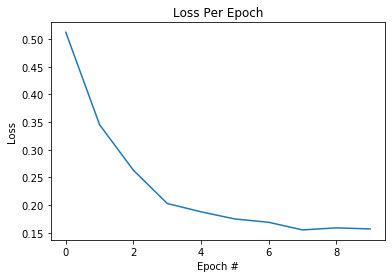

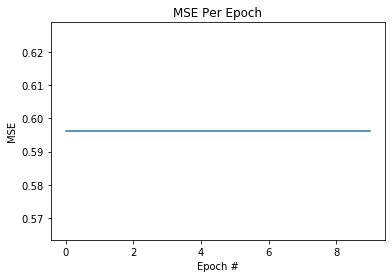

<Figure size 432x288 with 0 Axes>

In [47]:
sns.lineplot(x=np.array([x for x in range(EPOCH)]), y=np.array(TrainingLoss))
plt.title("Loss Per Epoch")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()
plt.clf()

sns.lineplot(x=np.array([x for x in range(EPOCH)]), y=np.array(TestingMSE))
plt.title("MSE Per Epoch")
plt.xlabel("Epoch #")
plt.ylabel("MSE")
plt.show()
plt.clf()

In [48]:
modelPerformance = []

for i, output in enumerate(zip(testOutput, predictedRatio)):
    target, prediction = output
    modelPerformance.append({"Example" : i, "True Ratio" : target , "Predicted Ratio" : prediction})
    
modelPerformance = pd.DataFrame(modelPerformance)
modelPerformance.head()

,Example,True Ratio,Predicted Ratio
0,0,0.48,0
1,1,0.96,0
2,2,0.90,0
3,3,0.52,0
4,4,0.95,0


In [22]:
trainInput, testInput, trainOutput, testOutput = train_test_split(inputClassificationData, outputClassificationData, test_size=0.1)
testOutput = [i[0] for i in testOutput]

class PredictRedditPost(nn.Module):
    def __init__(self):
        super(PredictRedditPost, self).__init__()
        self.linearClassifier = nn.Sequential(nn.Linear(352, 64), nn.Dropout(0.5), nn.ReLU(),
                                              nn.Linear(64, 16), nn.ReLU(),
                                              nn.Linear(16, 1))
        self.sigmoid = nn.Sigmoid()
    def forward(self, featureVector):
        return self.sigmoid(self.linearClassifier(featureVector))

In [23]:
LR = 1e-3
WEIGHTDECAY=0.0005
EPOCH = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = PredictRedditPost()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHTDECAY)
BCEL = nn.BCELoss()

TestingAccuracy = []
TrainingLoss = []
for STEP in range(1, EPOCH + 1):
    epochLoss = 0
    model.train()
    
    for batchCount, data in enumerate(zip(trainInput, trainOutput)):
        handCraftedFeatures, postType = data

        handCraftedFeatures = torch.tensor(handCraftedFeatures)
        postType = torch.tensor(postType)

        handCraftedFeatures = handCraftedFeatures.to(device)
        postType = postType.to(device)

        predictedPostType = model(handCraftedFeatures)

        optimizer.zero_grad()
        Loss = BCEL(predictedPostType, postType)
        epochLoss = epochLoss + Loss.item()

        Loss.backward()
        optimizer.step()

    print("Epoch " + str(STEP) + " Loss: " + str(epochLoss / batchCount))
    TrainingLoss.append(epochLoss / batchCount)
    
    model.eval()
    testInput = torch.tensor(testInput)
    testInput = testInput.to(device)
    predictedPostType = torch.round(model(testInput))

    predictedPostType = [int(i[0]) for i in predictedPostType.tolist()]
    Accuracy = metrics.accuracy_score(testOutput, predictedPostType)
    print("Epoch "+ str(STEP) + " Accuracy: " + str(Accuracy) + "\n")
    TestingAccuracy.append(Accuracy)

Epoch 1 Loss: 0.7069111705428917
Epoch 1Accuracy: 0.6797752808988764

Epoch 2 Loss: 0.6067645564089366
Epoch 2Accuracy: 0.6797752808988764

Epoch 3 Loss: 0.5543294027408772
Epoch 3Accuracy: 0.7359550561797753

Epoch 4 Loss: 0.48989452393715394
Epoch 4Accuracy: 0.7640449438202247

Epoch 5 Loss: 0.4100091924295452
Epoch 5Accuracy: 0.8426966292134831

Epoch 6 Loss: 0.41533701651001825
Epoch 6Accuracy: 0.8033707865168539

Epoch 7 Loss: 0.3871994945842338
Epoch 7Accuracy: 0.9213483146067416

Epoch 8 Loss: 0.36606456267170145
Epoch 8Accuracy: 0.9438202247191011

Epoch 9 Loss: 0.3757897629421671
Epoch 9Accuracy: 0.9325842696629213

Epoch 10 Loss: 0.445769505257246
Epoch 10Accuracy: 0.8258426966292135



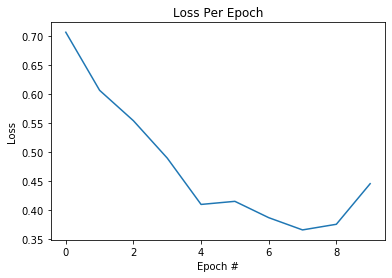

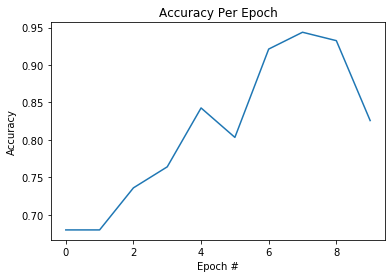

<Figure size 432x288 with 0 Axes>

In [24]:
sns.lineplot(x=np.array([x for x in range(EPOCH)]), y=np.array(TrainingLoss))
plt.title("Loss Per Epoch")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()
plt.clf()

sns.lineplot(x=np.array([x for x in range(EPOCH)]), y=np.array(TestingAccuracy))
plt.title("Accuracy Per Epoch")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.show()
plt.clf()